# Wie groß ist das System?

## 1. Verbindung zur Datenbank
Es wird eine Verbindung zur Neo4j-Datenbank aufgebaut.

In [1]:
import py2neo

graph = py2neo.Graph(bolt=True, host='localhost', user='neo4j', password='neo4j')

## 2. Cypher-Abfrage
Es wird eine Abfrage an die Datenbank gestellt. Das Ergebnis wird in einem Dataframe (pandas) gespeichert.

In [2]:
import pandas as pd

query ="MATCH (t:Type)-[:HAS_SOURCE]->(f), (t)-[:DECLARES]->(m:Method) RETURN sum(m.effectiveLineCount) as loc"
df = pd.DataFrame(graph.run(query).data())


## 3. Datenaufbereitung
Zur Kontrolle werden die ersten fünf Zeilen des Ergebnisses der Abfrage als Tabelle ausgegeben.

In [4]:
df.head()

,loc
0,833


Mithilfe von matplotlib wird die Visualisierung Gauge erstellt (http://nicolasfauchereau.github.io/climatecode/posts/drawing-a-gauge-with-matplotlib/).

In [5]:
import matplotlib
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle, Wedge, Rectangle
import numpy as np
import plotly.plotly as py
import plotly.tools as tls

def degree_range(n): 
    start = np.linspace(0,180,n+1, endpoint=True)[0:-1]
    end = np.linspace(0,180,n+1, endpoint=True)[1::]
    mid_points = start + ((end-start)/2.)
    return np.c_[start, end], mid_points

def rot_text(ang): 
    rotation = np.degrees(np.radians(ang) * np.pi / np.pi - np.radians(90))
    return rotation

def gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr Groß'], \
          colors='jet_r', arrow=1, title='', fname=False): 
    
    """
    some sanity checks first
    
    """
    
    N = len(labels)
    
    if arrow > N: 
        raise Exception("\n\nThe category ({}) is greated than \
        the length\nof the labels ({})".format(arrow, N))
 
    
    """
    if colors is a string, we assume it's a matplotlib colormap
    and we discretize in N discrete colors 
    """
    
    if isinstance(colors, str):
        cmap = cm.get_cmap(colors, N)
        cmap = cmap(np.arange(N))
        colors = cmap[::-1,:].tolist()
    if isinstance(colors, list): 
        if len(colors) == N:
            colors = colors[::-1]
        else: 
            raise Exception("\n\nnumber of colors {} not equal \
            to number of categories{}\n".format(len(colors), N))

    """
    begins the plotting
    """
    
    fig, ax = plt.subplots()

    ang_range, mid_points = degree_range(N)

    labels = labels[::-1]
    
    """
    plots the sectors and the arcs
    """
    patches = []
    for ang, c in zip(ang_range, colors): 
        # sectors
        patches.append(Wedge((0.,0.), .4, *ang, facecolor='w', lw=2))
        # arcs
        patches.append(Wedge((0.,0.), .4, *ang, width=0.10, facecolor=c, lw=2, alpha=0.5))
    
    [ax.add_patch(p) for p in patches]

    
    """
    set the labels (e.g. 'LOW','MEDIUM',...)
    """

    for mid, lab in zip(mid_points, labels): 

        ax.text(0.35 * np.cos(np.radians(mid)), 0.35 * np.sin(np.radians(mid)), lab, \
            horizontalalignment='center', verticalalignment='center', fontsize=14, \
            fontweight='bold', rotation = rot_text(mid))

    """
    set the bottom banner and the title
    """
    r = Rectangle((-0.4,-0.1),0.8,0.1, facecolor='w', lw=2)
    ax.add_patch(r)
    
    ax.text(0, -0.05, title, horizontalalignment='center', \
         verticalalignment='center', fontsize=22, fontweight='bold')

    """
    plots the arrow now
    """
    
    pos = mid_points[abs(arrow - N)]
    
    ax.arrow(0, 0, 0.225 * np.cos(np.radians(pos)), 0.225 * np.sin(np.radians(pos)), \
                 width=0.04, head_width=0.09, head_length=0.1, fc='k', ec='k')
    
    ax.add_patch(Circle((0, 0), radius=0.02, facecolor='k'))
    ax.add_patch(Circle((0, 0), radius=0.01, facecolor='w', zorder=11))

    """
    removes frame and ticks, and makes axis equal and tight
    """
    
    ax.set_frame_on(False)
    ax.axes.set_xticks([])
    ax.axes.set_yticks([])
    ax.axis('equal')
    plt.tight_layout()
    if fname:
        fig.savefig(fname, dpi=200)


Die Funktion <font face="Courier">calculate_level(loc)</font> bildet die Anzahl der Quelltextzeilen auf das Level des Gauge ab:

sehr klein (level=1): kleiner gleich 10000 <br/>
klein (level=2): zwischen 10000 und 50000 <br/>
mittel (level=3): zwischen 50000 und 200000 <br/>
groß (level=4): zwischen 200000 und 500000 <br/>
sehr groß (level=5): über 500000 <br/>

In [6]:
# Hole Wert an 0. Stelle im Dataframe.
loc = df.iloc[0]['loc']

# Errechne Level auf der Grundlage der Anzahl der Quelltextzeilen.
def calculate_level(loc):
    if loc <= 10000:
        level=1
    elif loc <= 50000:
        level=2
    elif loc <= 200000:
        level=3
    elif loc <= 500000:
        level=4
    else:
        level=5
    return(level)

## 4. Visualisierung
Die Daten werden mittels Gauge visualisiert (http://nicolasfauchereau.github.io/climatecode/posts/drawing-a-gauge-with-matplotlib/, labels='Sehr klein','Klein','Mittel','Groß','Sehr Groß', colors='RdYlGn', arrow= Rückgabewert der Funktion <font face="Courier">calculate_level(loc)</font>, title='Systemgröße').

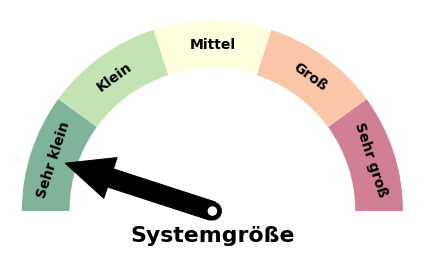

In [7]:
#Erstelle Gauge.
gauge(labels=['Sehr klein','Klein','Mittel','Groß','Sehr groß'], \
        colors='RdYlGn', arrow=calculate_level(loc), title='Systemgröße')
